In [1]:
from jaxtyping import ArrayLike
from flowjax.bijections.bijection import AbstractBijection
from flowjax.distributions import AbstractDistribution
import inspect
import jax.random as jr
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import warnings

from frugal_flows.causal_flows import (
    train_frugal_flow,
)

from flowjax.bijections import (
    Affine,
    Invert,
    Tanh,
)

from flowjax.distributions import Transformed, Uniform, _StandardUniform

from frugal_flows.bijections import UnivariateNormalCDF, LocCond, MaskedAutoregressiveFirstUniform
from flowjax.bijections.utils import Identity

from frugal_flows.sample_outcome import sample_outcome

jax.config.update("jax_enable_x64", True)

In [4]:
keys = jr.split(jr.PRNGKey(8), 50)

In [5]:

N = 10000

z = jr.multivariate_normal(keys[0], jnp.array([0.,0.]), jnp.array([[1., 0],[0, 1.]]), shape=(N,))


x = jnp.expand_dims(jnp.hstack([jnp.ones(int(N/2))*0, jnp.ones(int(N/2))*1]),axis=1)
y = jax.random.normal(keys[2], shape=(N,1)) + x + jnp.expand_dims(z.sum(1), axis=1)

u_z = jax.scipy.stats.norm.cdf(z, loc=0, scale=1)

In [7]:
frugal_flow, losses = train_frugal_flow(
    key = jr.PRNGKey(9),
    y=y,
    u_z=u_z,  # impose discrete
    RQS_knots= 8,
    nn_depth= 1,
    nn_width= 50,
    flow_layers= 5,
    learning_rate= 5e-2,
    max_epochs= 500,
    max_patience = 50,
    batch_size = 1000,
    condition=x,
    mask_condition=True,
    causal_model = 'location_translation',
    causal_model_args={'RQS_knots':8, 'flow_layers':5, 'nn_width':50, 'nn_depth':2, 'ate':5.},
)

 29%|███▊         | 146/500 [01:31<03:41,  1.60it/s, train=1.4345362236445558, val=1.4825072776609831 (Max patience reached)]


In [21]:
frugal_flow.bijection[-1].bijections[0].ate

Array(1.03780964, dtype=float64)

In [28]:
assert(isinstance(frugal_flow.bijection.bijections[4].bijections[0].bijection, Tanh))

In [26]:
frugal_flow.bijection.bijections[4].bijections[0].bijection

Tanh(shape=())

In [52]:
# def sample_outcome(
#     key: jr.PRNGKey,
#     n_samples: float,
#     causal_model: str,
#     causal_condition: ArrayLike | None = None,
#     frugal_flow: AbstractDistribution|None = None,
#     causal_cdf: AbstractBijection | None = UnivariateNormalCDF,
#     u_yx: ArrayLike | None = None,
#     **treatment_kwargs: dict,
# ):

#     valid_causal_models = ["logistic_regression", "causal_cdf", "location_translation"]

#     if ((u_yx is None)&(frugal_flow is None)):
#         raise ValueError ('Either a frugal flow object or u_yx is required')

#     if ((u_yx is not None)&(frugal_flow is not None)):
#         raise ValueError ('Only one between frugal flow object and u_yx can be provided')
    
#     if ((causal_model == 'location_translation')&(frugal_flow is None)):
#         raise ValueError ('A frugal flow object is required for simulating outcome with location_translation model')

#     if frugal_flow is not None:    
#         flow_dim = frugal_flow.shape[0]
    
#         if frugal_flow.cond_shape is None:
#             flow_fake_condition = None
#         else:
#             flow_fake_condition = jnp.ones((n_samples, frugal_flow.cond_shape[0]))
    
#         # verify flow has a compatible structure 
        
#         assert isinstance(frugal_flow.base_dist, _StandardUniform)
#         assert isinstance(frugal_flow.bijection.bijections[0].tree, Affine)
#         assert isinstance(frugal_flow.bijection.bijections[1].bijection.bijection.bijections[0], MaskedAutoregressiveFirstUniform)
        
#         maf_dim = frugal_flow.bijection.bijections[1].bijection.bijection.bijections[0].shape[0]
#         spline_n_params =  int(frugal_flow.bijection.bijections[1].bijection.bijection.bijections[0].masked_autoregressive_mlp.layers[-1].out_features/maf_dim)
#         assert(frugal_flow.bijection.bijections[1].bijection.bijection.bijections[0].transformer_constructor(jnp.ones((spline_n_params))).interval==1)
#         try:
#             assert(isinstance(frugal_flow.bijection.bijections[2].tree.bijections[0], Identity))
#         except:
#             assert((isinstance(frugal_flow.bijection.bijections[2].tree, Invert))&(isinstance(frugal_flow.bijection.bijections[2].tree.bijection, Affine)))
    
#         # obtain u_y samples from flow 
#         uni_standard = jr.uniform(key, shape=(n_samples, flow_dim))
#         uni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[0].tree.transform)(
#             uni_standard
#         )
    
#         corruni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[1].transform)(
#             uni_minus1_plus1, flow_fake_condition
#         )
#         corruni = jax.vmap(frugal_flow.bijection.bijections[2].tree.transform)(
#             corruni_minus1_plus1, flow_fake_condition
#         )
#         corruni_y = corruni[:, 0]
            
#         try:
#             assert(isinstance(frugal_flow.bijection.bijections[2].tree.bijections[0], Identity))
#             corruni_standard = corruni_y
#         except:
#             assert((isinstance(frugal_flow.bijection.bijections[2].tree, Invert))&(isinstance(frugal_flow.bijection.bijections[2].tree.bijection, Affine)))
#             corruni_standard = (corruni_y / 2) + 0.5

#     elif u_yx is not None:
#         assert len(u_yx) == n_samples
#         if (u_yx.min() < 0.0) | (u_yx.max() > 1.0):
#             raise ValueError ("u_yx input must be between 0. and 1.")
#         corruni_standard = u_yx

    
#     if causal_model == "logistic_regression":
#         outcome_samples = logistic_outcome(
#             u_y=corruni_standard, causal_condition=causal_condition, **treatment_kwargs,
#         )

#     elif causal_model == "causal_cdf":
#         outcome_samples, _ = causal_cdf_outcome(
#             u_y=corruni_standard,
#             causal_condition=causal_condition,
#             causal_cdf=causal_cdf,
#             **treatment_kwargs,
#         )

#     elif causal_model == "location_translation":
#         try:
#             assert(isinstance(frugal_flow.bijection.bijections[4].bijections[0].bijection, Tanh))
#         except:
#             raise ValueError ("location_translation causal_model requires a location_translation pretrained frugal_flow")
        
#         outcome_samples = location_translation_outcome(
#             u_y=corruni_standard,
#             causal_condition=causal_condition,
#             flow_condition=flow_fake_condition,
#             frugal_flow=frugal_flow,
#             **treatment_kwargs,
#         )
#     else:
#         raise ValueError(f"Invalid causal_model choice. Please choose from: {valid_causal_models}")

#     return outcome_samples


# def logistic_outcome(
#     u_y: ArrayLike, ate: float, causal_condition: ArrayLike, const: float
# ):
#     def get_y(u_y, ate, x, const):
#         p = jax.nn.sigmoid(ate * x + const)
#         return (u_y >= (1-p)).astype(int)

#     return jax.vmap(get_y, in_axes=(0, None, 0, None))(
#         u_y, ate, causal_condition, const
#     )


# def causal_cdf_outcome(
#     u_y: ArrayLike,
#     causal_cdf: AbstractBijection,
#     causal_condition: ArrayLike,
#     **treatment_kwargs: dict,
# ):
#     causal_cdf_init_params = [
#         i
#         for i in inspect.signature(causal_cdf.__init__).parameters.keys()
#         if ((i != "self") and (i != "cond_dim"))
#     ]
#     for param in causal_cdf_init_params:
#         if param not in treatment_kwargs.keys():
#             treatment_kwargs[param] = None
#             warnings.warn(
#                 f"The parameter {param} has not been provided and is therefore set to None."
#             )

#     causal_cdf_simulate = causal_cdf(**treatment_kwargs)
#     samples = jax.vmap(causal_cdf_simulate.inverse)(u_y, causal_condition)
#     return samples, causal_cdf_simulate


# def location_translation_outcome(
#     u_y: ArrayLike,
#     frugal_flow: AbstractDistribution,
#     causal_condition: ArrayLike,
#     flow_condition: ArrayLike,
#     **treatment_kwargs: dict,
# ):
#     causal_minus1_plus1 = jax.vmap(
#         frugal_flow.bijection.bijections[3].bijections[0].transform
#     )(u_y[:, None], flow_condition)
#     causal_reals = jax.vmap(
#         frugal_flow.bijection.bijections[4].bijections[0].transform
#     )(causal_minus1_plus1.flatten(), flow_condition)

#     loc_cond_cdf_simulate = LocCond(**treatment_kwargs)
#     samples = jax.vmap(loc_cond_cdf_simulate.transform)(causal_reals, causal_condition)
#     return samples


In [8]:
key= jr.PRNGKey(9),
n_samples=1000
causal_cdf=UnivariateNormalCDF, 
causal_condition= jnp.hstack([jnp.ones(int(n_samples/2))*0, jnp.ones(int(n_samples/2))*1]).astype(int)

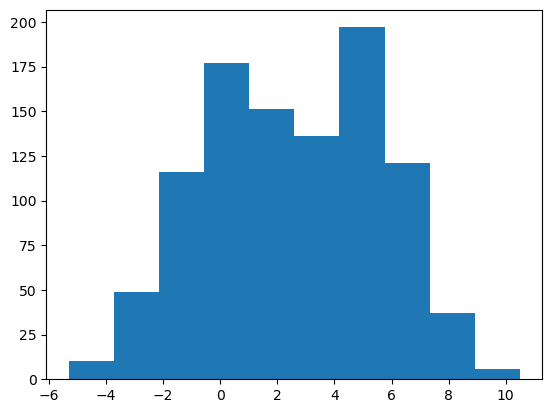

In [9]:
treatment_kwargs={'ate':5} #, 'const':0., 'scale':1.}
my_outcome = sample_outcome(
            frugal_flow=frugal_flow,
             key=keys[9],
            n_samples=n_samples,
            # u_yx=jr.uniform(keys[2],(n_samples,)),
            causal_model='location_translation',
            causal_condition=causal_condition[:,None], 
            **treatment_kwargs)

plt.hist(my_outcome);

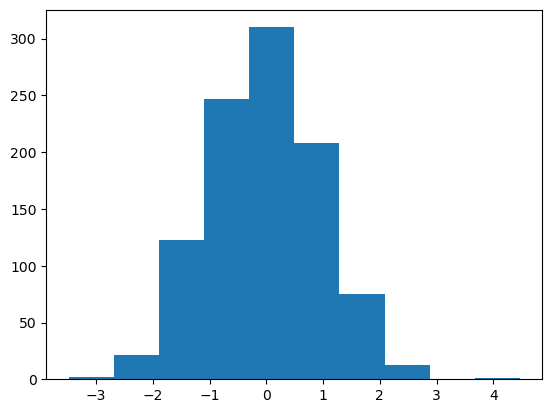

In [10]:
treatment_kwargs={'ate':5, 'const':0., 'scale':1.}
my_outcome  = sample_outcome(
            # frugal_flow=frugal_flow,
            u_yx=jr.uniform(keys[2],(n_samples,)),    
             key=keys[9],
            n_samples=n_samples,
            causal_model='causal_cdf',
            causal_cdf=UnivariateNormalCDF,
            causal_condition=causal_condition,  
            **treatment_kwargs)

plt.hist(my_outcome);

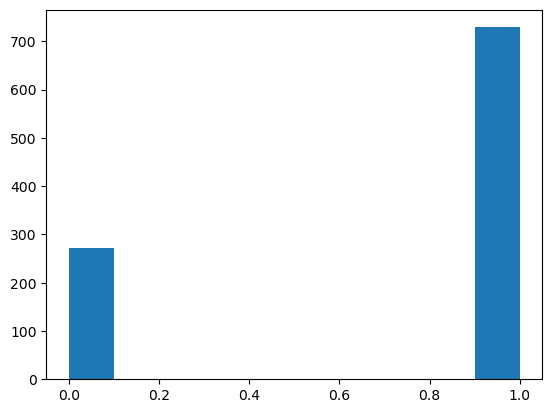

In [11]:
treatment_kwargs={'ate':5, 'const':0.}
my_outcome = sample_outcome(
            # frugal_flow=frugal_flow,
            u_yx=jr.uniform(keys[2],(n_samples,)),    
             key=keys[9],
            n_samples=n_samples,
            causal_model='logistic_regression',
            causal_cdf=UnivariateNormalCDF,
            causal_condition=causal_condition,  
            **treatment_kwargs)

plt.hist(my_outcome);